In [1]:
import sys
# For data
sys.path.append('/afs/inf.ed.ac.uk/user/s13/s1301730/Documents/discriminitive_turns_project/discriminative_turns/')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Global imports
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
# Local imports 
from conversational_corpus import *

In [6]:
# Load the corpus data
with open( "/disk/scratch/swallbridge/pickles/swb_corpus.p", 'rb' ) as fp:
    swb_corpus = pickle.load(fp)
a = swb_corpus.load_speaker_turns(transcript_clean_fn=clean_transcript_swbc)
    
# with open( "/disk/scratch/swallbridge/pickles/fe_corpus_acceptable_utter_responses.p", "rb" ) as fp:
#     fe_corpus = pickle.load(fp)

## Characterize the datasets

In [6]:
# Some basic stats
print('FISHER')
print(f'conversations       : {len(fe_corpus.conversations)}')
print(f'conv_utter_responses: {len(fe_corpus.conv_utter_responses)}')
print(f'conv_utters         : {len(fe_corpus.conv_utters)}')
print(f'conv_responses      : {len(fe_corpus.conv_responses)}')
print(f'conv_turns          : {len(fe_corpus.conv_turns)}')
# print(f'unique tokens       : {len(fe_tok_c)}')
# print(f'total tokens        : {sum(fe_tok_c.values())}')

print('\nSWB')
print(f'conversations       : {len(swb_corpus.conversations)}')
print(f'conv_utter_responses: {len(swb_corpus.conv_utter_responses)}')
print(f'conv_utters         : {len(swb_corpus.conv_utters)}')
print(f'conv_responses      : {len(swb_corpus.conv_responses)}')
print(f'conv_turns          : {len(swb_corpus.conv_turns)}')
# print(f'unique tokens       : {len(swb_tok_c)}')
# print(f'total tokens        : {sum(swb_tok_c.values())}')

FISHER
conversations       : 5850
conv_utter_responses: 153720
conv_utters         : 1114202
conv_responses      : 0
conv_turns          : 713682

SWB
conversations       : 2438
conv_utter_responses: 43977
conv_utters         : 264333
conv_responses      : 0
conv_turns          : 180337


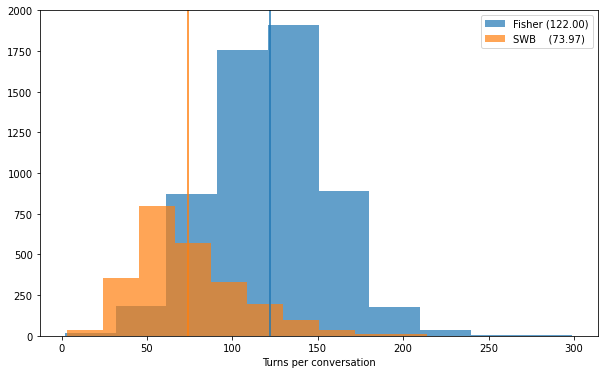

In [7]:
# Count turns per conversation
swb_turn_df = pd.DataFrame(swb_corpus.conv_turns)
fe_turn_df = pd.DataFrame(fe_corpus.conv_turns)

swb_turn_lengths = list(swb_turn_df['conv_id'].value_counts())
fe_turn_lengths = list(fe_turn_df['conv_id'].value_counts())

f, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(fe_turn_lengths, label=f'Fisher ({np.mean(fe_turn_lengths):.2f})', color='C0', alpha=0.7)
ax.hist(swb_turn_lengths, label=f'SWB    ({np.mean(swb_turn_lengths):.2f})', color='C1', alpha=0.7)

ax.axvline(np.mean(fe_turn_lengths), color='C0')
ax.axvline(np.mean(swb_turn_lengths),  color='C1')

ax.set_xlabel('Turns per conversation')
ax.legend()


## Consider some cleaning...
TODO; didn't finish this. The cleaning is not standardized between the 2 datasets

In [8]:
print("Empty 'cleaned' turns")
print(f" - SWB: {sum([1 for t in swb_corpus.conv_turns if len(t['clean_text']) < 1]) / len(swb_corpus.conv_turns) * 100:.1f}%")
print(f" - FE : {sum([1 for t in fe_corpus.conv_turns if len(t['clean_text']) < 1]) / len(fe_corpus.conv_turns) * 100:.1f}%")

print("Empty 'cleaned' utterances")
print(f" - SWB: {sum([1 for t in swb_corpus.conv_utters if len(t['clean_text']) < 1]) / len(swb_corpus.conv_utters) * 100:.1f}%")
print(f" - FE : {sum([1 for t in fe_corpus.conv_utters if len(t['clean_text']) < 1]) / len(fe_corpus.conv_utters) * 100:.1f}%")


Empty 'cleaned' turns
 - SWB: 3.6%
 - FE : 10.6%
Empty 'cleaned' utterances
 - SWB: 5.9%
 - FE : 13.6%


In [7]:
# m=20
# mm=50
[c['clean_text'] for c in swb_corpus.conv_turns if 'um-hum' in c['clean_text']][:5]

['um-hum all right', 'um-hum', 'uh-huh um-hum', 'um-hum', 'um-hum']

In [79]:
# [c['clean_text'] for c in fe_corpus.conv_turns if 'huh' in c['clean_text']]

## Making datasets for Post Training `BERT-FP`

In [85]:
# Get the turns per conversation
swb_conv_turns = swb_turn_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
fe_conv_turns = fe_turn_df.groupby('conv_id')['clean_text'].apply(list).to_dict()

In [92]:
len(swb_conv_turns), len(fe_conv_turns)


(2438, 5850)

In [109]:
# Splin into train, test, val (and small test)
from sklearn.model_selection import train_test_split
swb_train, swb_testing = train_test_split(list(swb_conv_turns.keys()), test_size=0.2, random_state=1)
swb_val, swb_test = train_test_split(swb_testing, test_size=0.5, random_state=1)

_, swb_train_small = train_test_split(swb_train, test_size=0.005, random_state=1)


1950 244 244 10


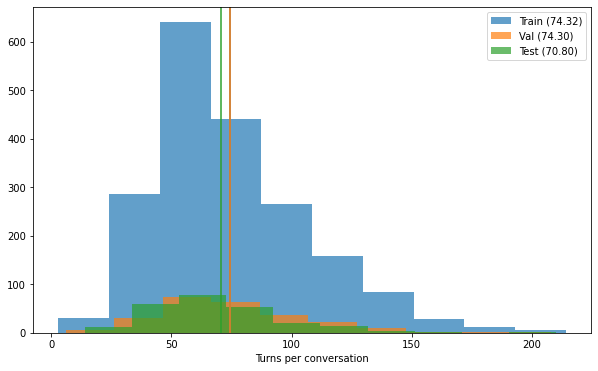

In [111]:
print(len(swb_train), len(swb_val), len(swb_test), len(swb_train_small))

# Count turns per conversation
swb_train_small_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_train_small)]
swb_train_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_train)]
swb_val_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_val)]
swb_test_df = swb_turn_df[swb_turn_df.conv_id.isin(swb_test)]

swb_train_lengths = list(swb_train_df['conv_id'].value_counts())
swb_val_lengths = list(swb_val_df['conv_id'].value_counts())
swb_test_lengths = list(swb_test_df['conv_id'].value_counts())

f, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(swb_train_lengths, label=f'Train ({np.mean(swb_train_lengths):.2f})', color='C0', alpha=0.7)
ax.hist(swb_val_lengths, label=f'Val ({np.mean(swb_val_lengths):.2f})', color='C1', alpha=0.7)
ax.hist(swb_test_lengths, label=f'Test ({np.mean(swb_test_lengths):.2f})', color='C2', alpha=0.7)

ax.axvline(np.mean(swb_train_lengths), color='C0')
ax.axvline(np.mean(swb_val_lengths), color='C1')
ax.axvline(np.mean(swb_test_lengths), color='C2')


ax.set_xlabel('Turns per conversation')
ax.legend()

In [119]:
# Write them as list of lists
swb_train_small_dict = swb_train_small_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
swb_train_dict = swb_train_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
swb_val_dict = swb_val_df.groupby('conv_id')['clean_text'].apply(list).to_dict()
swb_test_dict = swb_test_df.groupby('conv_id')['clean_text'].apply(list).to_dict()

swb_train_small_turns = list(swb_train_small_dict.values())
swb_train_turns = list(swb_train_dict.values())
swb_val_turns = list(swb_val_dict.values())
swb_test_turns = list(swb_test_dict.values())

with open('spoken_data/swb_train_small.pkl', 'wb') as fp:
    pickle.dump(swb_train_small_turns, fp)
    
with open('spoken_data/swb_train.pkl', 'wb') as fp:
    pickle.dump(swb_train_turns, fp)
    
with open('spoken_data/swb_val.pkl', 'wb') as fp:
    pickle.dump(swb_val_turns, fp)
    
with open('spoken_data/swb_test.pkl', 'wb') as fp:
    pickle.dump(swb_test_turns, fp)

## Create the fine-tuning datasets
full and short-context versions (save each in eg. SWB_dataset_2409.pkl, v SWB_dataset_3923948.pkl)

In [16]:
from FPT.swb_final import BERTDataset, InputExample, convert_example_to_features
from transformers import BertTokenizer,BertConfig

06/03/2022 19:32:08 - INFO - FPT.swb_final -   CUDA info: device 0, name: GeForce GTX 1080 Ti


In [17]:
# Create the fine-tuning datasets
args = {
    'bert_model': 'bert-base-uncased', 
    'do_lower_case': False, 
    'gradient_accumulation_steps': 1, 
    'learning_rate': 1.5e-05, 
    'max_seq_length': 240, 
    'num_train_epochs': 25.0, 
    'output_dir': './FPT/PT_checkpoint/switchboard', 
    'train_batch_size': 8, 
    'train_file': './spoken_data/swb_train_small.pkl', 
    'warmup_proportion': 0.01
        }


tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

special_tokens_dict = {'eos_token': '[eos]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

#     bertconfig = BertConfig.from_pretrained(args.bert_model)
#     model = BertForPreTraining.from_pretrained(args.bert_model, config=bertconfig)

#     model.resize_token_embeddings(len(tokenizer))
#     model.cls.seq_relationship = nn.Linear(bertconfig.hidden_size, 3)
#     #load checkpoint here
#     #model.bert.load_state_dict(state_dict=torch.load("ubuntu_final/checkpoint20-1637300/bert.pt"))
#     model.to(device)

train_small_dataset = BERTDataset(args['train_file'], tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
train_dataset = BERTDataset('./spoken_data/swb_train.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
val_dataset = BERTDataset('./spoken_data/swb_val.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)
test_dataset = BERTDataset('./spoken_data/swb_test.pkl', tokenizer, seq_len=args['max_seq_length'],
                            corpus_lines=None)


06/03/2022 19:32:09 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /afs/inf.ed.ac.uk/user/s13/s1301730/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
06/03/2022 19:32:09 - INFO - transformers.tokenization_utils -   Adding [eos] to the vocabulary
06/03/2022 19:32:09 - INFO - transformers.tokenization_utils -   Assigning [eos] to the eos_token key of the tokenizer
  5%|▍         | 94/1950 [00:00<00:01, 931.61it/s]

0 0


 36%|███▋      | 89/244 [00:00<00:00, 884.12it/s]

0 1


 42%|████▏     | 103/244 [00:00<00:00, 1027.63it/s]

0 0


100%|██████████| 244/244 [00:00<00:00, 1252.78it/s]

0 0


In [67]:
# # For each item in Dataset.sample_to_doc, create n negatives, tokenize both appropriately, append sample to 'cr' and label to 'y'
# len(train_dataset), len(val_dataset), len(test_dataset)

# for elem in train_dataset.







In [68]:
samples = [(i, s) for (i, s) in enumerate(train_dataset.sample_to_doc) if s['end'] > 0]
sample = samples[0]
print(sample)
# ll = train_dataset.get_random_lines(sample, num_negs=2)

(77925, {'doc_id': 867, 'line': 0, 'end': 3, 'linenum': 1})


In [99]:
# dailogue session length < short context length k.

def make_ft_sample(self, item, num_negs, seed=123):
    """
    Method to build fine-tuning datasets (same format as stimuli in ubuntu_dataset_1M.py) from short-contexts.
    
    For a given sample, select num_neg negative turns from anywhere in the corpus.
    """
    sample = self.sample_to_doc[item]
    length = sample['end']
    
    # Get the context
    if length != 0:
        tokens_a = []
        for i in range(length - 1):
            tokens_a+=self.tokenizer.tokenize(self.all_docs[sample["doc_id"]][i])+[self.tokenizer.eos_token]
        tokens_a.pop()

        response_sample = {"doc_id": sample["doc_id"], "line": length - 1}
        response = self.all_docs[sample["doc_id"]][length - 1]

    else:
        t1 = self.all_docs[sample["doc_id"]][sample["line"]]
        t2 = self.all_docs[sample["doc_id"]][sample["line"] + 1]
        t3 = self.all_docs[sample["doc_id"]][sample["line"] + 2]
        tokens_a = self.tokenizer.tokenize(t1)+[self.tokenizer.eos_token]+self.tokenizer.tokenize(t2)+[self.tokenizer.eos_token]+self.tokenizer.tokenize(t3)

        response_sample = {"doc_id": sample["doc_id"], "line": sample["line"] + 3}
        response = self.all_docs[sample["doc_id"]][sample["line"] + 3]
    
    # Get negative responses
    neg_responses = self.get_random_lines(response_sample, num_negs, seed=seed)    
    tokens_bs = [self.tokenizer.tokenize(response)]
    for n in neg_responses:
        tokens_bs.append(self.tokenizer.tokenize(n))
#     tokens_negs = [self.tokenizer.tokenize(n) for n in neg_responses]


    print('CONTEXT')
    print(sample["doc_id"], sample["line"])
    print(t1)
    print(t2)
    print(t3)
    
    print('RESPONSE')
    print(response_sample)
    print(self.all_docs[response_sample["doc_id"]][response_sample["line"]])
    print(response)
    print('NEGATIVES')
    display(neg_responses) 

    # Join samples and convert to ids
    tokenized_samples = [self.tokenizer.convert_tokens_to_ids(tokens_a + [self.tokenizer.eos_token] + [self.tokenizer.sep_token] + tokens_b) for tokens_b in tokens_bs]
    
    # Build labels
    ys = [1]
    ys.extend(list(np.zeros(num_negs, dtype=int)))

    return tokenized_samples, ys

def make_ft_doc(self, item, num_negs, seed=123):
    """
    Method to build fine-tuning datasets (same format as stimuli in ubuntu_dataset_1M.py) from full dialogues.
    
    For a given sample, select num_neg negative turns from anywhere in the corpus.
    """
    doc = self.all_docs[item]
    length = len(doc)
    
    # Get the context
    tokens_a = []
    for i in range(length - 1):
        tokens_a+=self.tokenizer.tokenize(doc[i])+[self.tokenizer.eos_token]
    tokens_a.pop()

    response_sample = {"doc_id": item, "line": length - 1} # TODO CHECK THIS WORKS
    response = doc[length - 1]
    
#     print('CONTEXT')
#     print(doc[-5:])
    
#     print('RESPONSE')
#     print(response_sample)
#     print(self.all_docs[response_sample["doc_id"]][response_sample["line"]])
#     print(response)
    
    # Get negative responses
    neg_responses = self.get_random_lines(response_sample, num_negs, seed=seed)  
    tokens_bs = [self.tokenizer.tokenize(response)]
    for n in neg_responses:
        tokens_bs.append(self.tokenizer.tokenize(n))

    # Join samples and convert to ids
    tokenized_samples = [self.tokenizer.convert_tokens_to_ids(tokens_a + [self.tokenizer.eos_token] + [self.tokenizer.sep_token] + tokens_b) for tokens_b in tokens_bs]
    
#     print('NEGATIVES')
#     print(neg_responses)    
    
    # Build labels
    ys = [1]
    ys.extend(list(np.zeros(num_negs, dtype=int)))

    return tokenized_samples, ys





In [104]:
tokenized_samples, ys = make_ft_sample(val_dataset, 22, 9, seed=123)

CONTEXT
0 22
yeah
as far as you know paying off the the the loan that you just got from the credit card to pay off the other loan
yeah that's what he's talking about doing now
RESPONSE
{'doc_id': 0, 'line': 25}
oh no um yeah the ATM's they're but they're nice though to have in case you need to get some quick cash and everything is closed
oh no um yeah the ATM's they're but they're nice though to have in case you need to get some quick cash and everything is closed
NEGATIVES


["oh i'm ready yeah sure",
 'neat',
 "yeah because i'm always looking at those guys i love them",
 "uh yes i i've read uh several good books lately uh lot of them uh related to um business and financial matters since that's what i do for a living",
 "either savings or investment one of the two but we don't ever put it at a high risk it's just always gonna be there",
 'okay and uh',
 'oh man',
 'yeah',
 'goodness']

In [115]:
# Make the sample-version of FT dataset

swb_dset = []

dset = train_small_dataset # val_dataset test_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 1)
    cr.extend(tokenized_samples)
    y.extend(ys)
swb_dset.append({'cr':cr, 'y':y})

dset = val_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 9)
    cr.extend(tokenized_samples)
    y.extend(ys)
swb_dset.append({'cr':cr, 'y':y})

dset = test_dataset
cr = []
y = []
for i in tqdm(range(len(dset.all_docs))):
    tokenized_samples, ys = make_ft_doc(dset, i, 9)
    cr.extend(tokenized_samples)
    y.extend(ys)
swb_dset.append({'cr':cr, 'y':y})
    

100%|██████████| 244/244 [00:11<00:00, 21.54it/s]


In [120]:
print(len(swb_dset))
print(len(swb_dset[0]))
print(len(swb_dset[0]['cr']), len(swb_dset[0]['y']))

n=121
# print(swb_dset[1]['cr'][n])
print(swb_dset[1]['y'][n])
(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(swb_dset[1]['cr'][n]))).split('[eos]')


3
2
20 20
0


["so uh how ' s the weather by you ",
 ' if it had rained any more in the last two weeks instead of planting [UNK] [UNK] grass in the front yard i think i would have pl ##owed everything under and had a rice field ',
 " i i heard that it ' s been raining down there a little bit but it ' s really been that bad ",
 " it ' s so bad wanted to mo ##w today i was off and i wanted to mo ##w the yard but just walking across it it ' s still so mu ##sh ##y if i took a mo ##wer out there i ' d tear the so ##d up so bad ",
 " really that bad huh is it is it typically this rain - i don ' t think it ' s typically this rainy by you down there is it ",
 " it ' s steady but it ' s not in the amounts that we been getting normally we get an inch here and then a week or so will pass and you pick up another inch inch and a half we ' re getting hit by three and four inch bursts at a time ",
 " oh [UNK] i guess you ' re getting all of [UNK] ' s rain ",
 " well that ' s where the front had came come from they

In [121]:
with open('spoken_data/switchboard_dataset_samples.pkl', 'wb') as fp:
    pickle.dump(swb_dset, fp)

In [15]:
len(train_small_dataset.all_docs)

10

In [96]:
display(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(toks[0])).split('[eos]'))
display(' '.join(train_dataset.tokenizer.convert_ids_to_tokens(toks[1])).split('[eos]'))


["you go ahead and start tell me how you ' d you ' d organize ",
 " well why don ' t you start because you ' ve had more time to think about if you don ' t mind ",
 " [SEP] okay the things that came across you know they said to make it memorable memorable but i thought first of all you needed to kind of about the same time every year like the same week of the the same month and and then you ' d have to send out uh you know good flyers and then mail to all that you wanted to attend and of course food and fun are going to be your your ways to get people there um the ones that i ' ve attended some have had breakfast and lunch and it ' s been a whole day affair some of course just have lunch or um also like at [UNK] time it ' d be a dinner reunion and uh all kinds of events are usually held i ' ve seen talents for mainly the kids that are there and you need probably information about your ancestors to tie that tie you to -"]

["you go ahead and start tell me how you ' d you ' d organize ",
 " well why don ' t you start because you ' ve had more time to think about if you don ' t mind ",
 ' [SEP] three years okay']

1

In [12]:
with open('spoken_data/switchboard_dataset_samples.pkl', 'rb') as fp:
    swb_dset = pickle.load(fp)
train, val, test = swb_dset

In [18]:
train['y'][:5]
train['cr'][2]

[7632,
 8529,
 3398,
 1045,
 1005,
 1040,
 2066,
 2000,
 2831,
 2055,
 2129,
 2017,
 4377,
 2005,
 2147,
 1998,
 1998,
 8529,
 2054,
 2079,
 2017,
 5373,
 2054,
 2828,
 1997,
 11018,
 2079,
 2017,
 5373,
 2031,
 2000,
 4929,
 30522,
 2092,
 1045,
 2147,
 1999,
 7910,
 5971,
 2491,
 2061,
 2057,
 2031,
 2000,
 4377,
 2785,
 1997,
 3835,
 2061,
 1045,
 2788,
 4929,
 18184,
 1998,
 14329,
 2015,
 1999,
 1996,
 3467,
 2051,
 27786,
 1045,
 3984,
 1998,
 1999,
 1996,
 2621,
 2074,
 14464,
 30522,
 8529,
 1011,
 14910,
 30522,
 102,
 2057,
 2064,
 1005,
 1056,
 2130,
 2092,
 2057,
 1005,
 2128,
 2025,
 2130,
 2428,
 4011,
 2000,
 4929,
 6312,
 2200,
 2411,
 2061,
 2009,
 2428,
 2987,
 1005,
 1056,
 8137,
 2008,
 2172,
 2013,
 2161,
 2000,
 2161,
 2144,
 1996,
 2436,
 2003,
 2785,
 1997,
 2017,
 2113,
 2467,
 1996,
 2168,
 4860]

In [71]:
def is_subtoken(word):
    if word[:2] == "##":
        return True
    else:
        return False

def detokenize(ids, tokenizer, ):
    tokens = tokenizer.convert_ids_to_tokens(ids)
    
    restored_text = []
    for i in range(len(tokens)):
        if len(restored_text) > 1 and (restored_text[-1] == "'" or restored_text[-1] == "-"):
            restored_text[-1] = restored_text[-2] + restored_text[-1] + tokens[i]
            del restored_text[-2]
        elif not is_subtoken(tokens[i]) and (i+1)<len(tokens) and is_subtoken(tokens[i+1]):
            restored_text.append(tokens[i] + tokens[i+1][2:])
            if (i+2)<len(tokens) and is_subtoken(tokens[i+2]):
                restored_text[-1] = restored_text[-1] + tokens[i+2][2:]
        elif not is_subtoken(tokens[i]):
            restored_text.append(tokens[i])
    return ' '.join(restored_text)

def split_text(text):
    context, response = text.split(' [SEP] ')
    context = context[:-6].split('[eos] ')
    return context, response

def restore_text(ids, tokenizer):
    raw_text = detokenize(ids, tokenizer) 
    return split_text(raw_text)
    

c, r = restore_text(train['cr'][6], tokenizer) 
c, r

    
    



(['um-hum ',
  "we can't even well we're not even really supposed to wear jeans very often so it really doesn't vary that much from season to season since the office is kind of you know always the same temperature ",
  'and is right right is there is there um an-is there a like a code of dress where you work do they ask'],
 'so not formally')

In [72]:
train_strings = [restore_text(ids, tokenizer) for ids in tqdm(train['cr'][:100])]

100%|██████████| 100/100 [00:00<00:00, 3309.38it/s]


In [77]:
type(swb_dset)

list